<a href="https://colab.research.google.com/github/leukschrauber/LearningPortfolio/blob/main/learn_portfolio_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Portfolio
*by Fabian Leuk (csba6437/12215478)*

## Session 2: Regression

### Key Learnings

1.   Consider the Business Context of a ML Application
2.   Select a Performance Measure before starting
3.   Use Descriptive Statistics to understand the data structure
4.   Use Visualizations and Correlations to understand relationships in the data.
5.   Lock away a Test-Set before starting to work on the data.
6.   Find ways to combine attributes to find better correlations.
7.   The most work is Data Cleaning and Transformation.
8.   Transform numerical attributes to the same scale before applying ML Algorithms. (Standardization, Min-Max-Scaling)
9.   Apply One-Hot-Encoding or numerical transformation for categorical attributes. 
10.  Remove Skewedness of data by applying logarithmic transformation.
11.  Use Cross-Validation to select the best model.
12.  Use Grid Search or Random Search to tune hyperparameters.
13.  Monitor performance of the system and it's inputs.
14.  Use SKLearn Framework to powerfully create Data Transformations, Metrics, and Data Pipelines.
15.  Use Stratified Sampling to preserve data set characteristics when diving the data set into training and test set.
16.  Impute missing values by for example using the Median. Or: Drop columns or rows.
17.  Use Mathplotlib Framework to visualize data powerfully.
18.  Evaluate different models to select the best model with validation.
19.  Use Joblib Framework to save and retrieve models.
20.  "Probieren geht über Studieren". :-)



### Application: Predicting Weekly Sales Data

I will apply the learnings to a dataset I retrieved from kaggle. (https://www.kaggle.com/datasets/yasserh/walmart-dataset) The goal of the built models will be to predict weekly sales for a supermarket. The data set consists of eight columns:



*   Store Number: ID of a Store
*   Date: Week of the weekly sales data
*   Weekly_Sales: ID of a Store
*   Holiday_Flag: Whether there was a public holiday
*   Temperature: Temperature on the Date (assumed in Fahrenheit)
*   Fuel_Price: Prevailing fuel price
*   CPI: Prevailing Consumer Price Index
*   Unemployment: Prevailing unemployment rate

In the Kaggle Dataset, there is no business context given. Let's assume following business need: Walmart wants to predict sales of a store for the next week. This information will be the input to another ML-System calculating order amounts for perishaeble food such as fruits and vegetables for each store.

The model will be evaluated on the RMSE-Measure.

The task is a supervised regression task using batch learning.


#### Data Import

In [105]:
import pandas as pd
from google.colab import drive
from google.colab import data_table
import matplotlib.pyplot as plt
import numpy as np
data_table.enable_dataframe_formatter()

drive.mount('/content/drive')
data = pd.read_csv("/content/drive/My Drive/SE_Digital_Organizations/Walmart.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Descriptive Statistics

In [ ]:
data.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


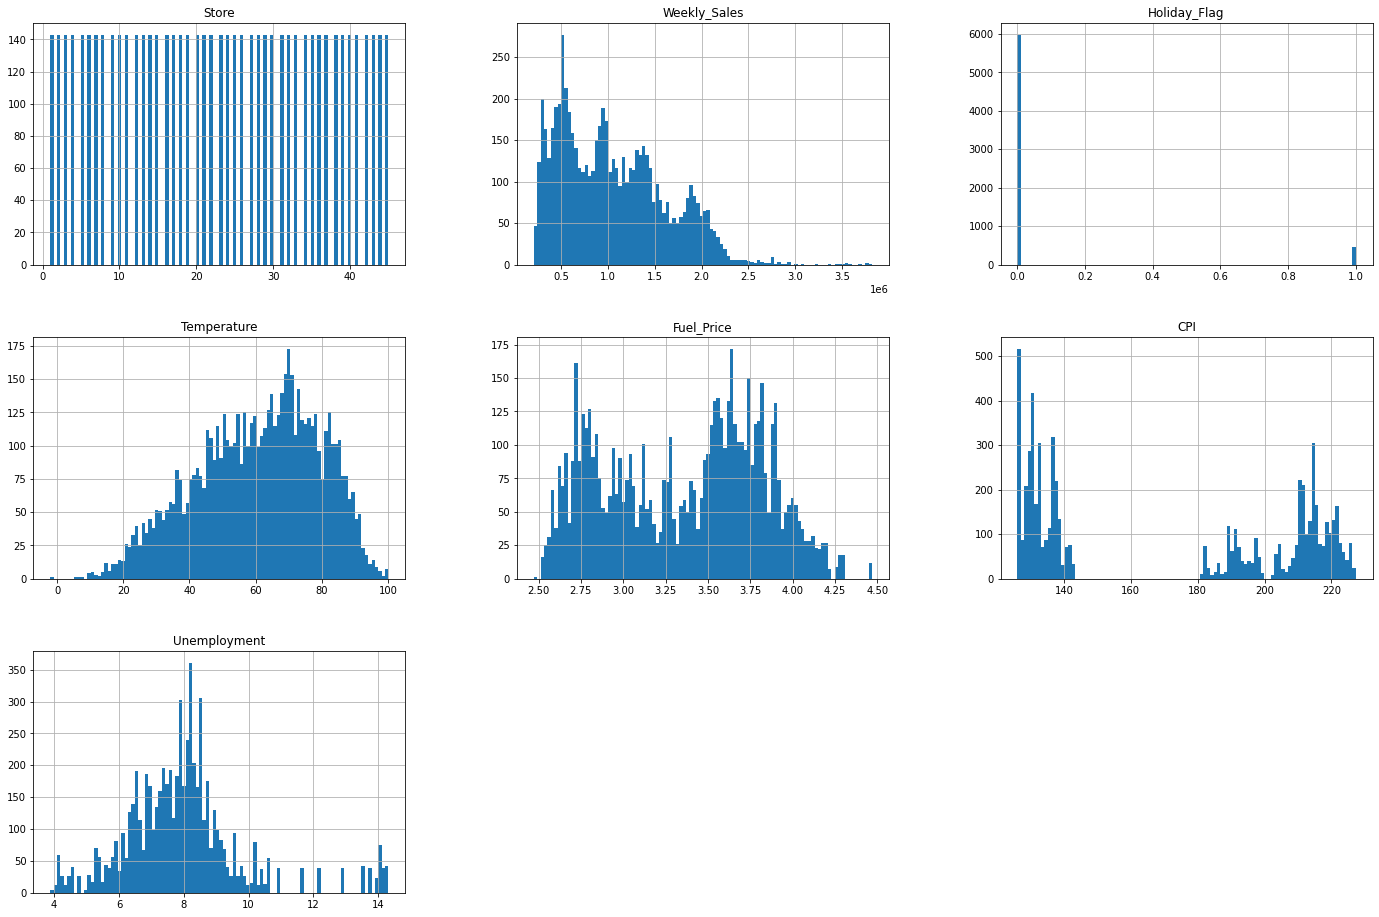

In [2]:
data.hist(bins=100, figsize=(24, 16))
plt.show()

Let's sum up some distinct data features that we gathered by looking at the data previously: 

Store: Every store is encoded as one number. The data set contains an equal amount of data for each store. I should definitely make sure this characteristic of the data set preserved by using stratified sampling. Maybe I can use the stores as clusters for the final model or else I might one-hot encode the categories.

Weekly_Sales: Right-Skewed => Logarithmic Transformation

Temperature: 

Fuel_Price: Multi-Modal => Logarithmic Transformation

CPI: Multi-Modal => Let's try logarithmic transformation for the beginning

Unemployment: Right-Skewed => Logarithmic Transformation

Date: Transformation needed. As I worked in retail, I know that the calendar week of a year is important for revenue. Thus, I'll transform them to calendar weeks and years and one-hot encode them.

#### Data Cleaning

In [114]:
# Transform dates to calendar week
data['Week'] = pd.to_datetime(data["Date"]).dt.isocalendar().week
data['Year'] = pd.to_datetime(data["Date"]).dt.isocalendar().year
data = data.drop("Date", axis=1)

# We got Time Series Data. So we are adding the previous week sale for each store to the row
# As will be shown later, it is a really good predictor for this week's sale.
def calculate_previous_week_sales(df):
  df = df.sort_values(['Year', 'Week'], ascending=True)
  df['Prev_Week_Sales'] = df.groupby('Store')['Weekly_Sales'].shift(1)
  mean_sales = df.groupby('Store')['Weekly_Sales'].mean()
  df['Prev_Week_Sales'] = df.apply(lambda row: mean_sales[row['Store']] if pd.isna(row['Prev_Week_Sales']) else row['Prev_Week_Sales'], axis=1)
  return df

data = calculate_previous_week_sales(data)

/usr/local/lib/python3.9/dist-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '19-02-2010' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/usr/local/lib/python3.9/dist-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '26-02-2010' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/usr/local/lib/python3.9/dist-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '19-03-2010' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/usr/local/lib/python3.9/dist-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '26-03-2010' in DD/MM/YYYY format. Provide format or specify infer_datetime

#### Sampling Training Data

In [115]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(data, test_size=0.2, stratify=data["Store"], random_state=42)
data = train_set.copy()

#### Correlations

In [116]:
data.corr()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Week,Year,Prev_Week_Sales
Store,1.000000,-0.335417,0.004954,-0.025779,0.064177,-0.208638,0.220733,-0.004133,0.014049,-0.335467
Weekly_Sales,-0.335417,1.000000,0.031716,-0.060927,0.023844,-0.071051,-0.103272,0.078451,-0.016468,0.929986
Holiday_Flag,0.004954,0.031716,1.000000,-0.169414,-0.065670,-0.006913,0.014692,0.331267,-0.038762,0.053652
Temperature,-0.025779,-0.060927,-0.169414,1.000000,0.154395,0.173456,0.114435,0.055594,0.062373,-0.049773
Fuel_Price,0.064177,0.023844,-0.065670,0.154395,1.000000,-0.177061,-0.031839,-0.046284,0.776119,0.024866
CPI,-0.208638,-0.071051,-0.006913,0.173456,-0.177061,1.000000,-0.295346,0.010265,0.066992,-0.072912
Unemployment,0.220733,-0.103272,0.014692,0.114435,-0.031839,-0.295346,1.000000,0.000155,-0.234298,-0.103066
Week,-0.004133,0.078451,0.331267,0.055594,-0.046284,0.010265,0.000155,1.000000,-0.129121,0.072048
Year,0.014049,-0.016468,-0.038762,0.062373,0.776119,0.066992,-0.234298,-0.129121,1.000000,-0.009513
Prev_Week_Sales,-0.335467,0.929986,0.053652,-0.049773,0.024866,-0.072912,-0.103066,0.072048,-0.009513,1.000000


Besides the almost perfect correlation between Weekly_Sales and Prev_Week_Sales, there seems to be no strong linear relationship to any of the variables.

#### Visualize data

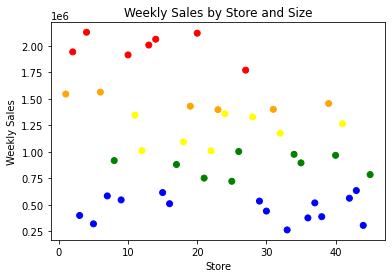

In [117]:
weekly_sales_mean_per_store = data.groupby("Store")["Weekly_Sales"].mean()
mean_sales_bins = pd.cut(weekly_sales_mean_per_store, bins=5, labels=range(1,6))
mean_sales_bins = mean_sales_bins.rename("Size")
store_data = pd.concat([weekly_sales_mean_per_store, mean_sales_bins], axis=1)

size_color_map = {1: 'blue', 2: 'green', 3: 'yellow', 4: "orange", 5: "red"}

plt.scatter(store_data.index, store_data['Weekly_Sales'], c=store_data['Size'].map(size_color_map))

plt.xlabel('Store')
plt.ylabel('Weekly Sales')
plt.title('Weekly Sales by Store and Size')

plt.show()

I have chosen this data visualization to undermine that there are different store types. It shows that the weekly sales of the weakest store is an eigth of the weekly sales of the strongest selling store. I plan to use this feature of the data by one-hot-encoding the Store IDs.

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:100: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:91: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])


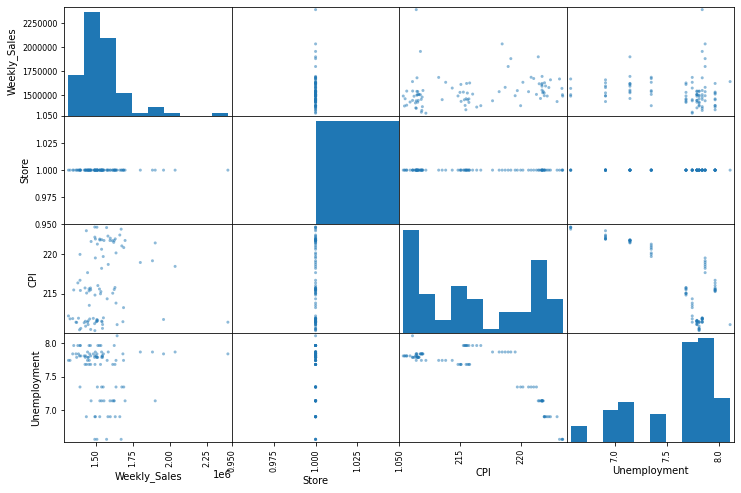

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:100: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:91: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])


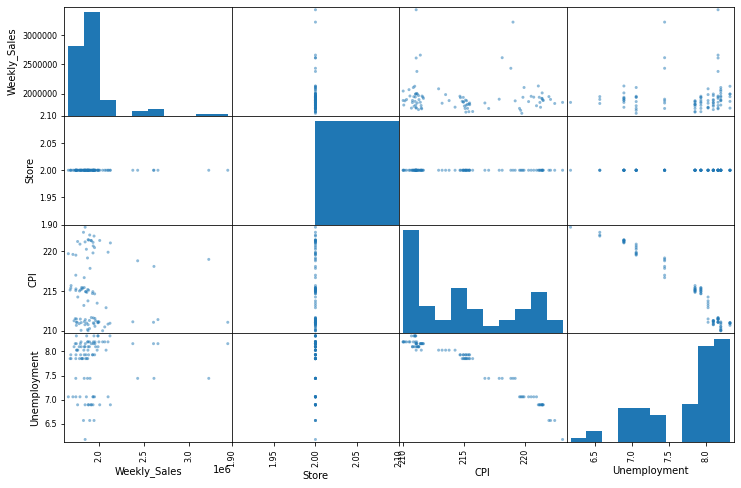

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:100: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:91: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])


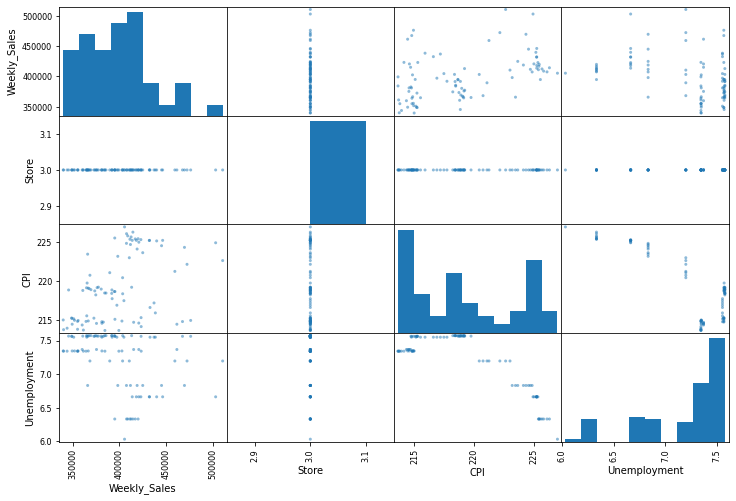

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:100: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:91: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])


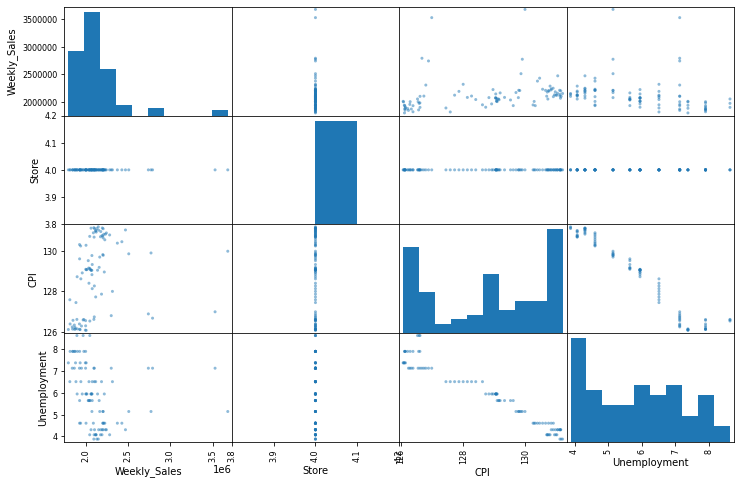

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:100: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:91: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])


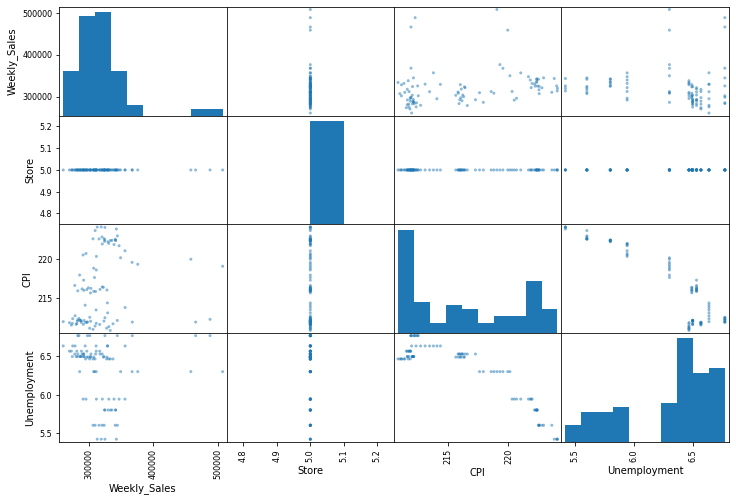

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:100: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:91: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])


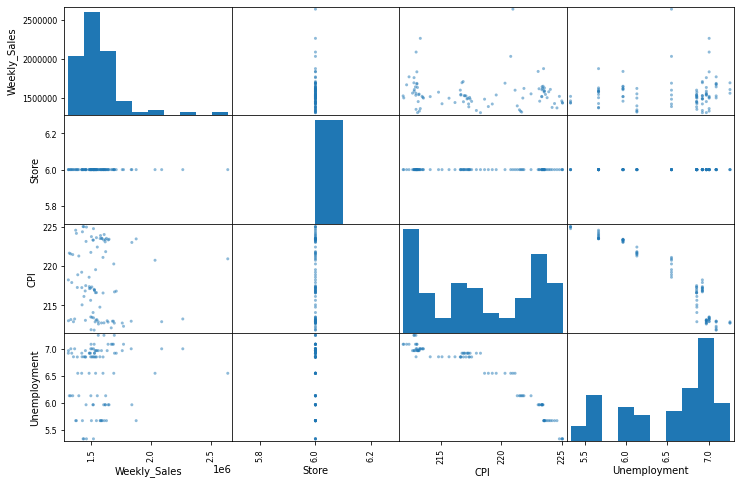

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:100: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:91: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])


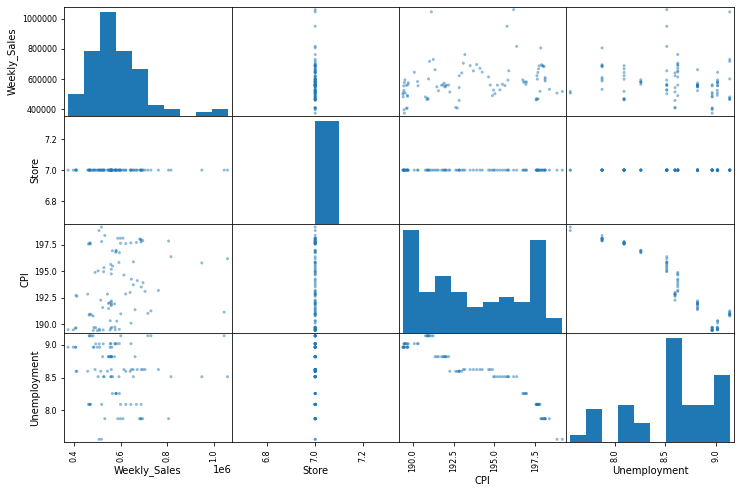

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:100: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:91: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])


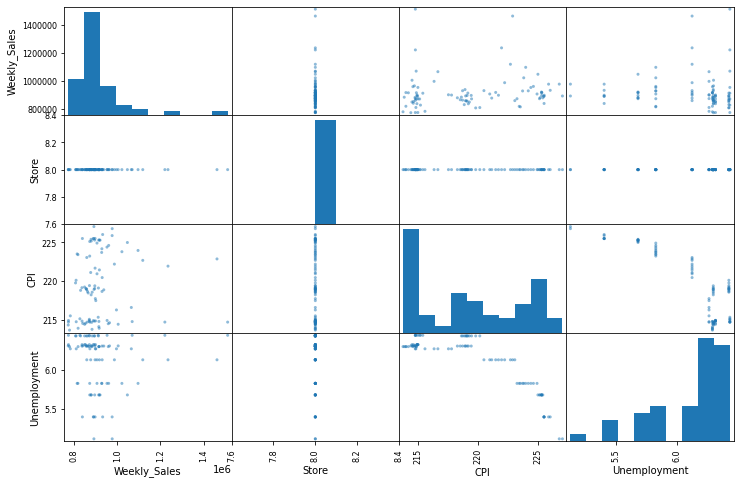

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:100: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:91: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])


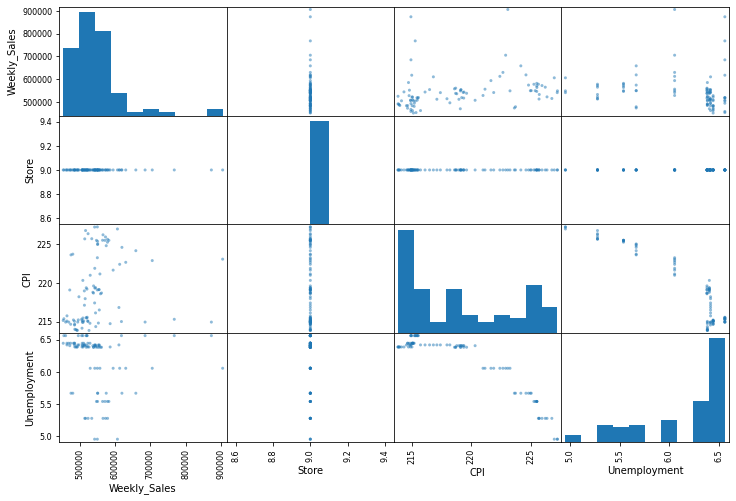

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:100: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:91: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])


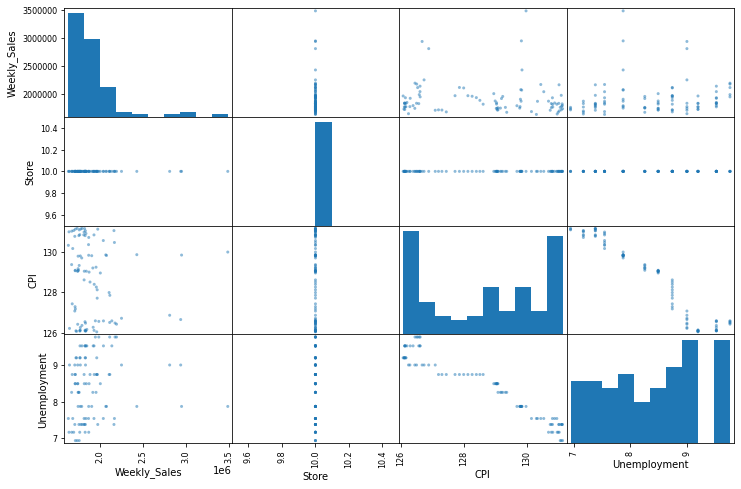

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:100: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:91: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])


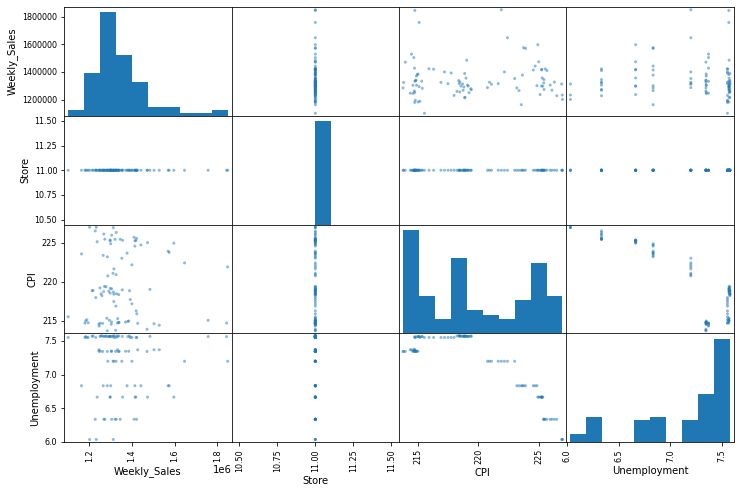

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:100: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:91: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])


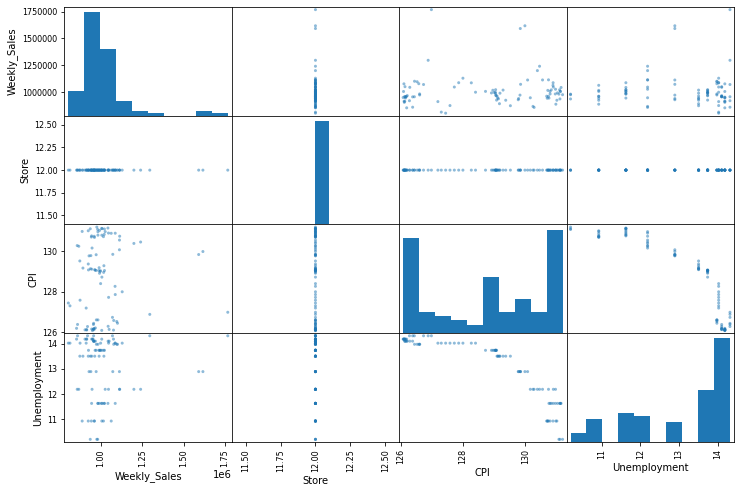

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:100: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:91: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])


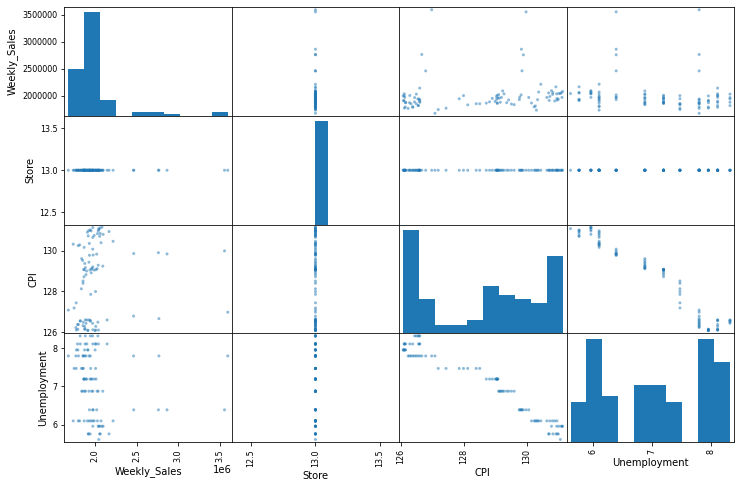

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:100: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:91: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])


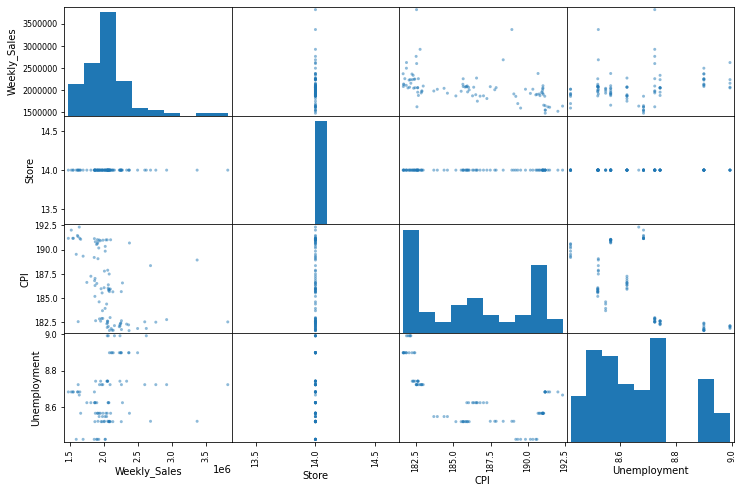

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:100: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:91: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])


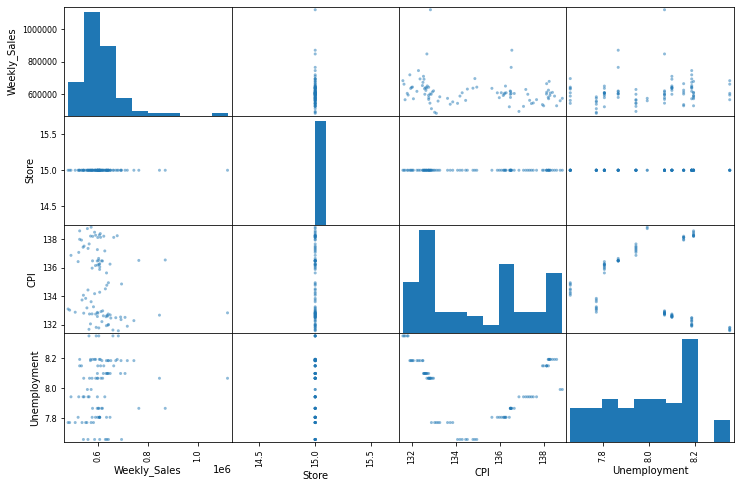

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:100: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:91: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])


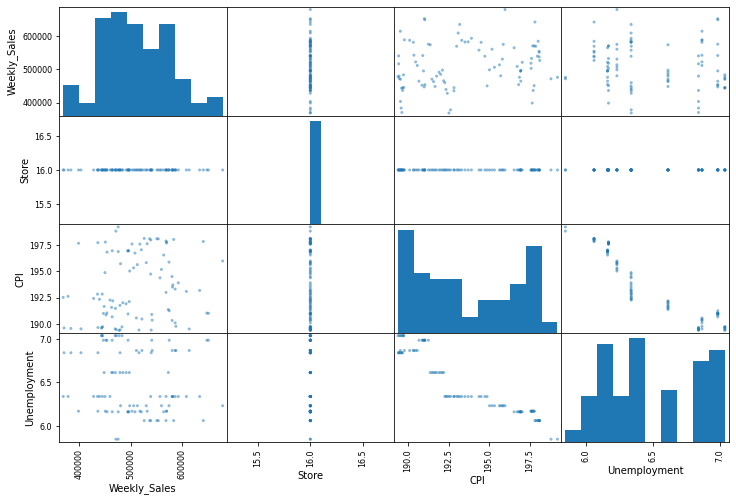

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:100: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:91: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])


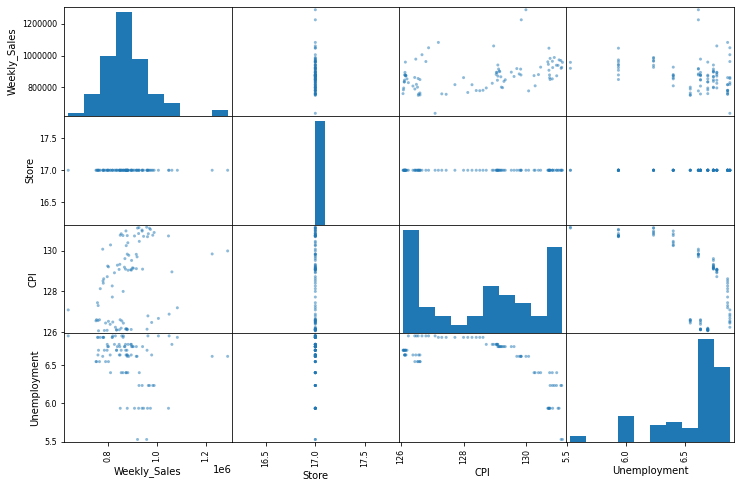

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:100: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:91: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])


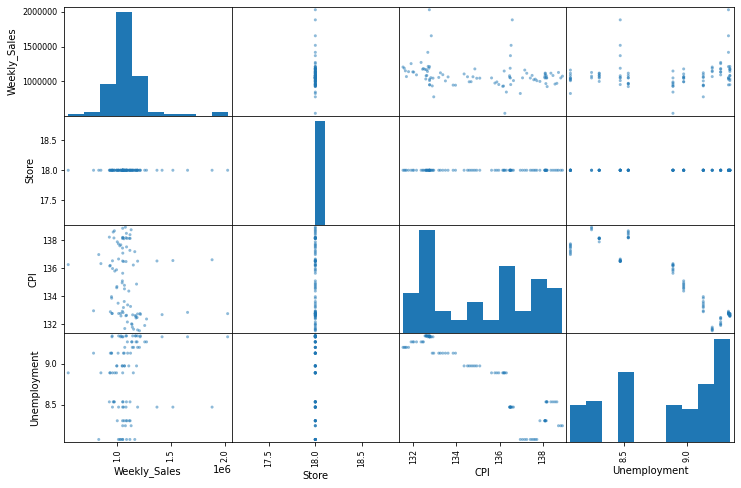

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:100: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:91: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])


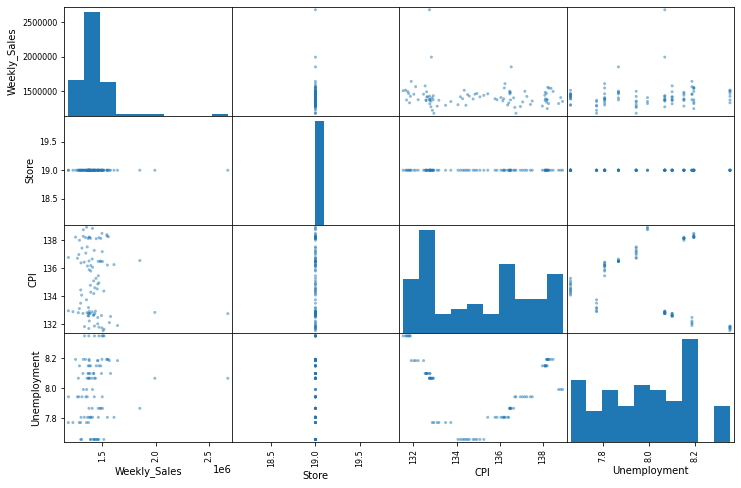

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:100: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:91: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])


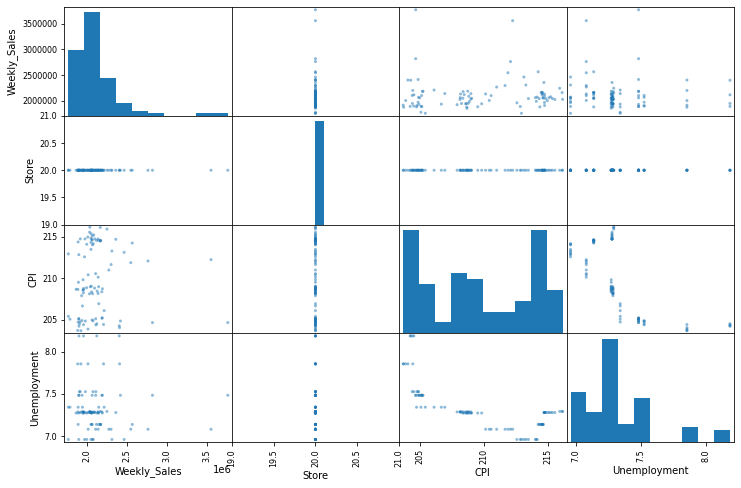

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:100: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:91: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])


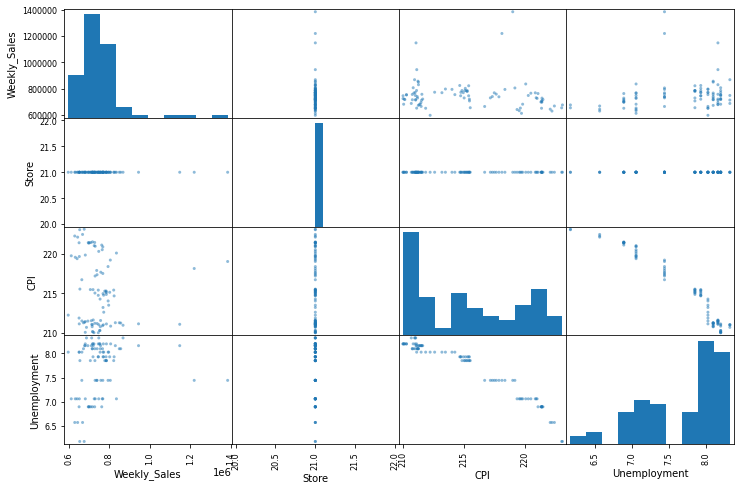

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:100: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:91: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])


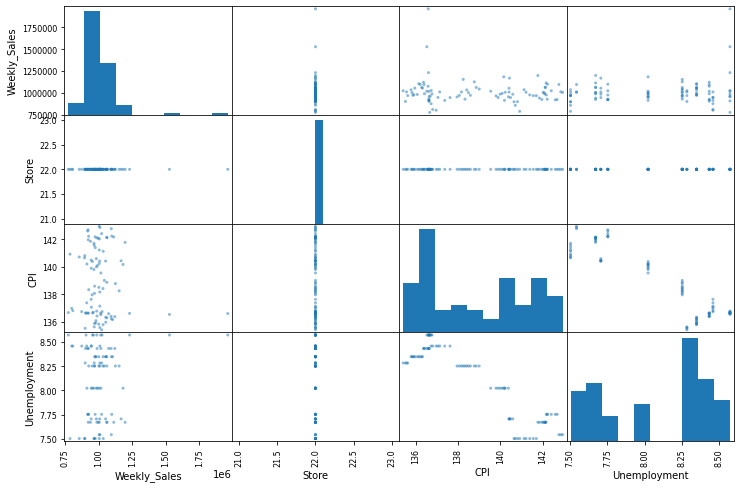

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:100: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:91: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])


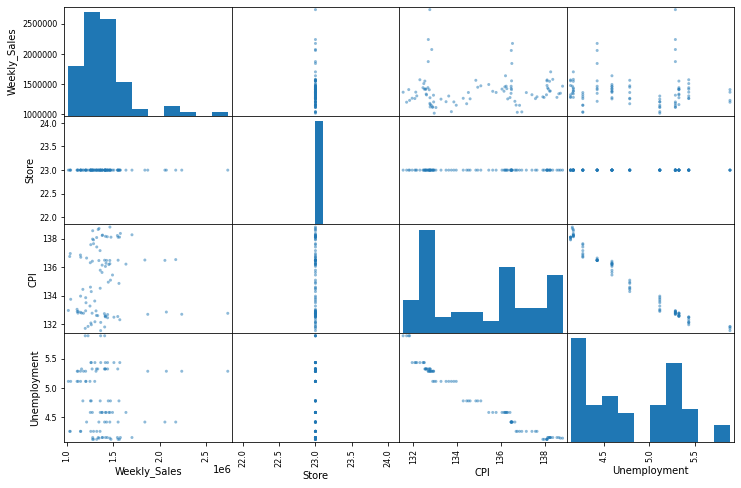

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:100: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:91: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])


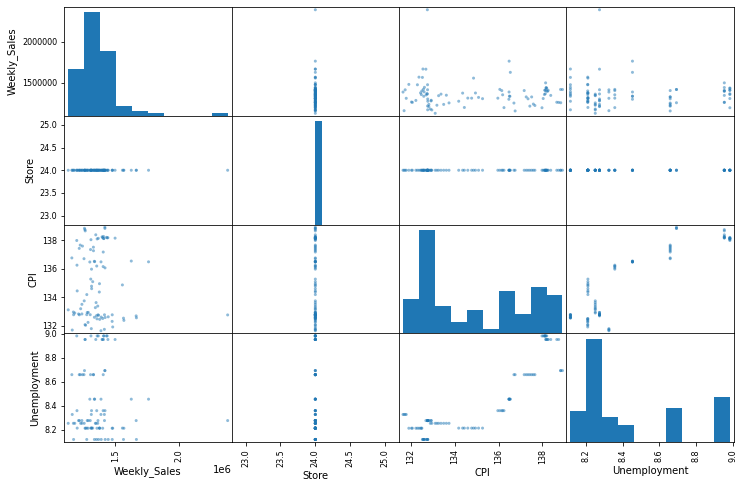

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:100: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:91: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])


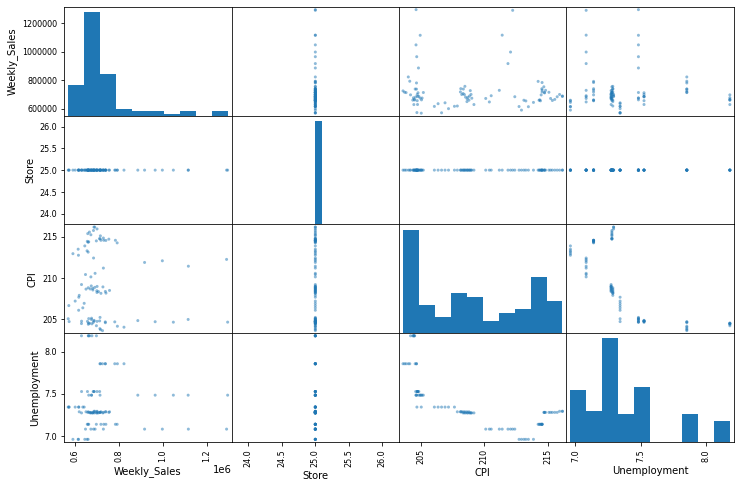

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:100: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:91: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])


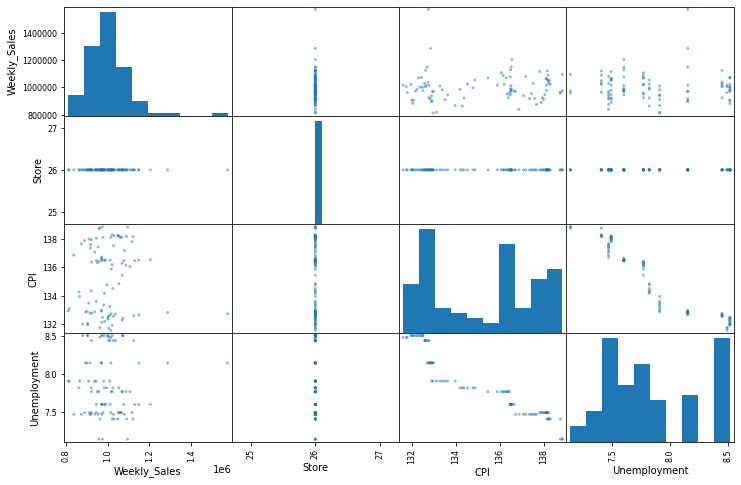

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:100: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:91: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])


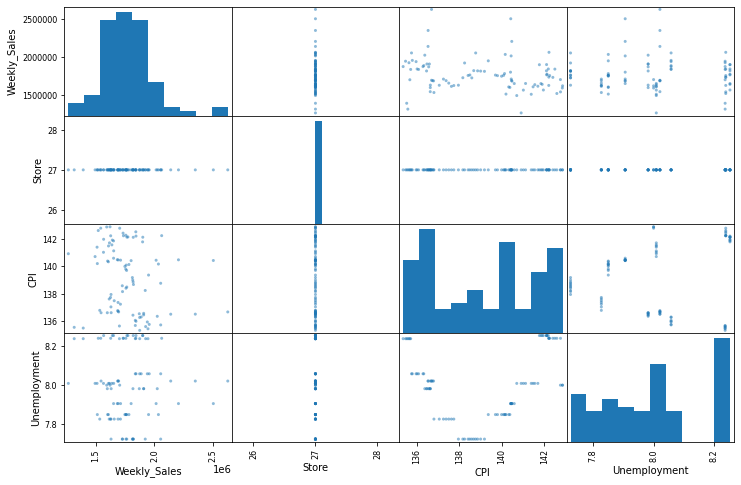

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:100: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:91: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])


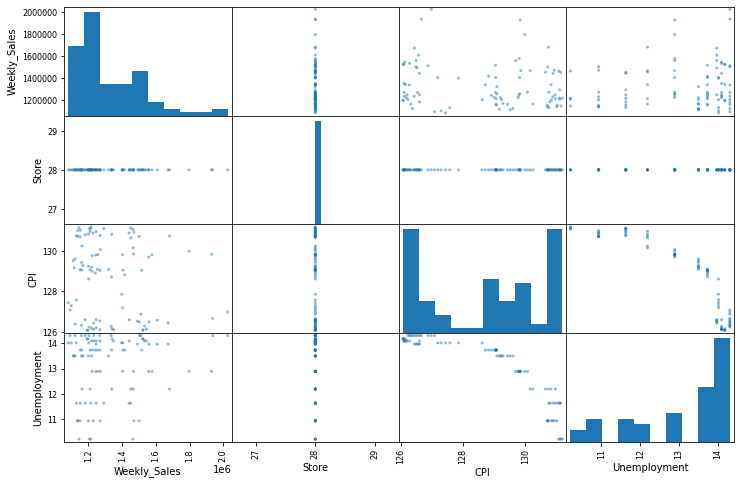

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:100: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:91: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])


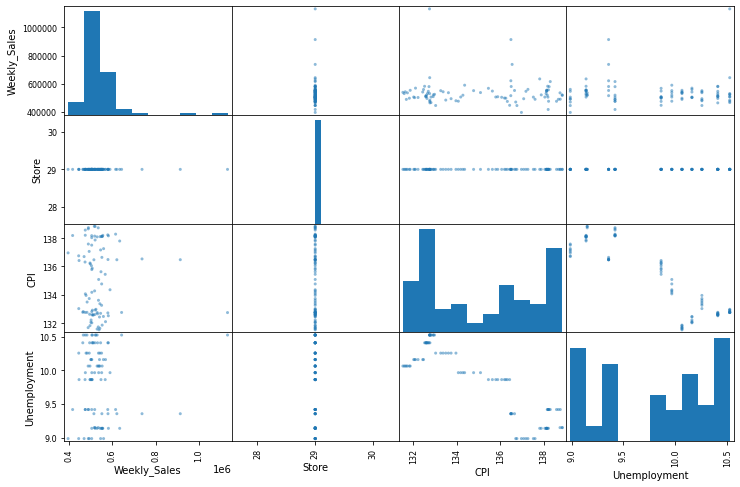

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:100: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:91: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])


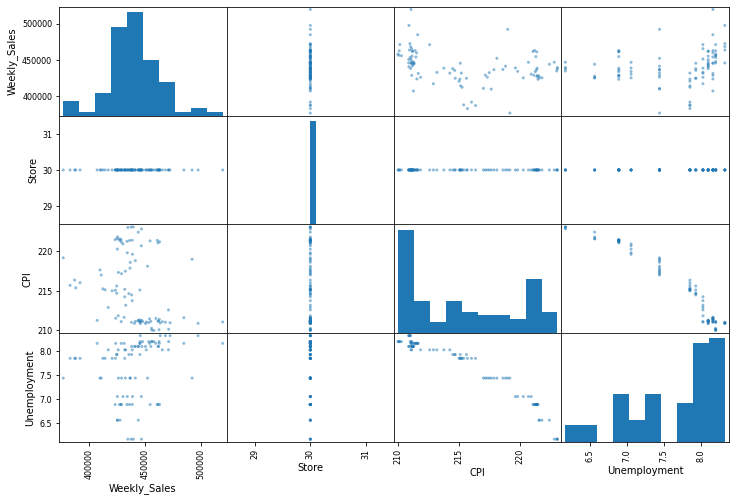

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:100: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:91: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])


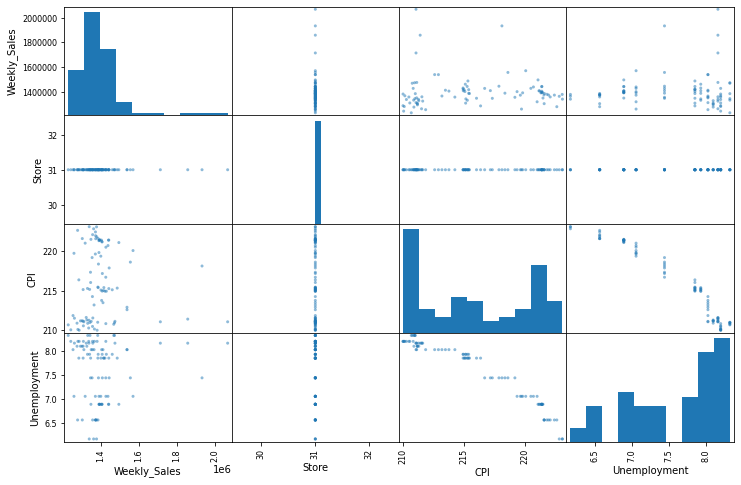

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:100: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:91: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])


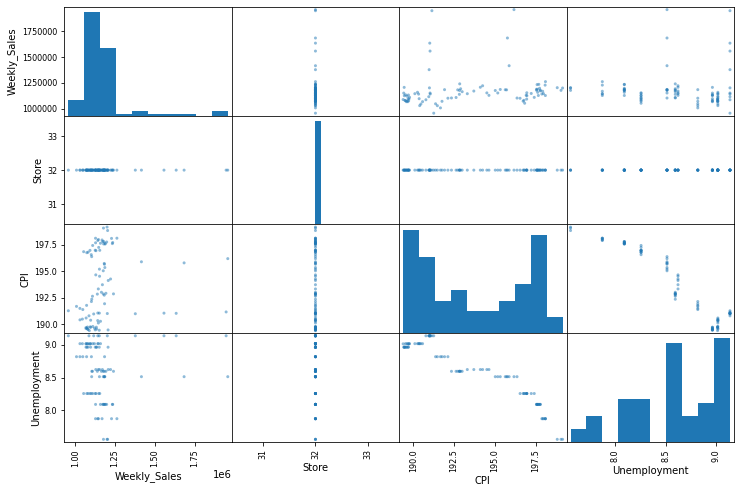

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:100: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:91: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])


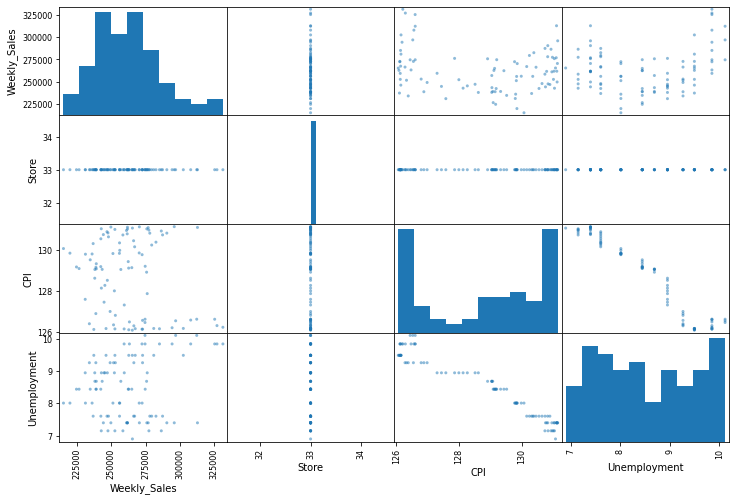

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:100: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:91: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])


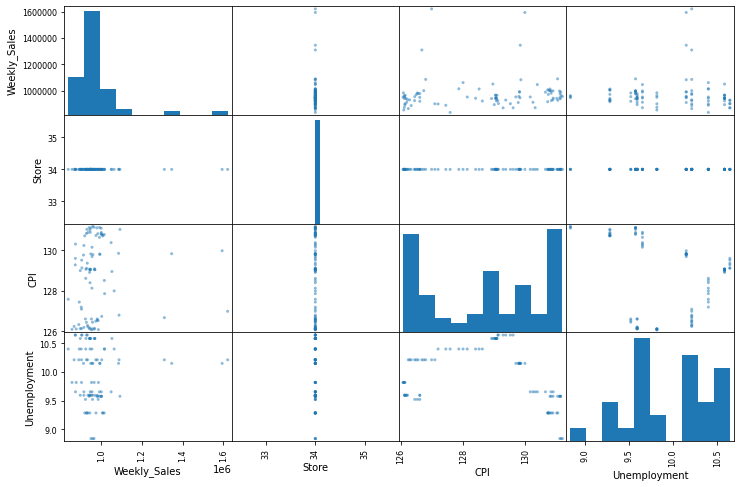

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:100: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:91: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])


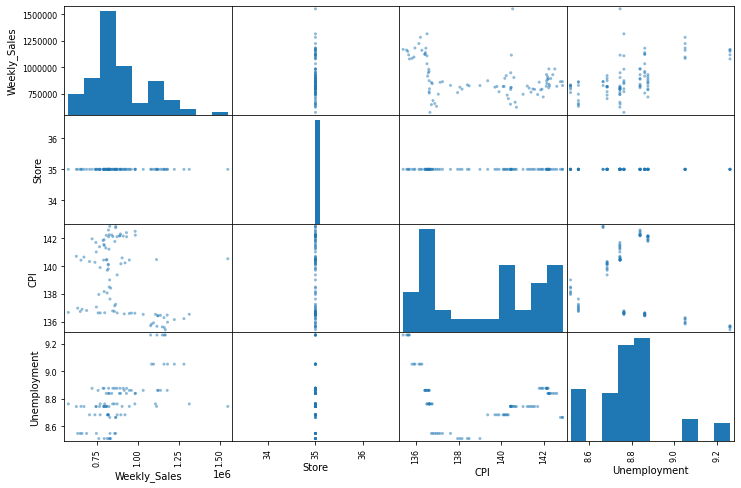

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:100: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:91: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])


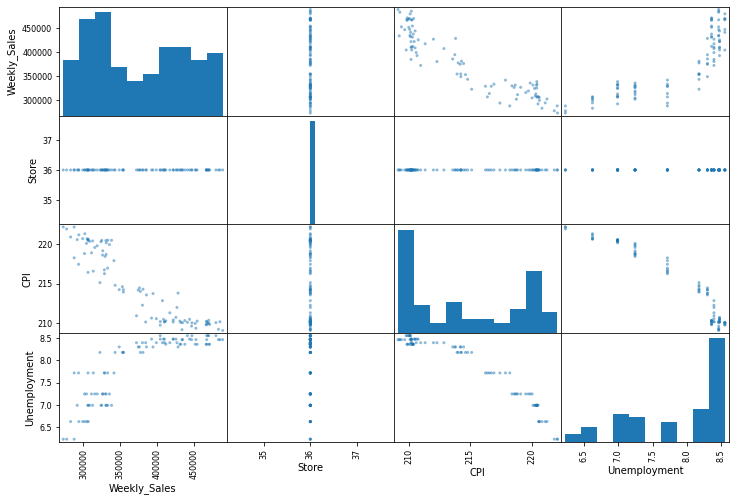

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:100: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:91: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])


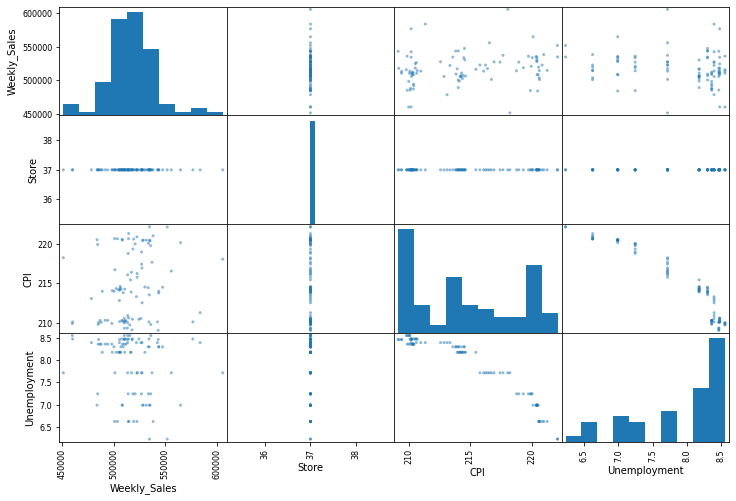

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:100: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:91: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])


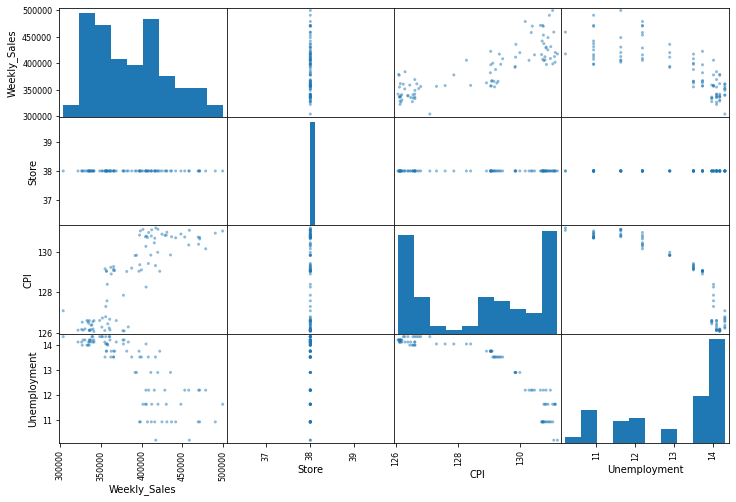

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:100: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:91: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])


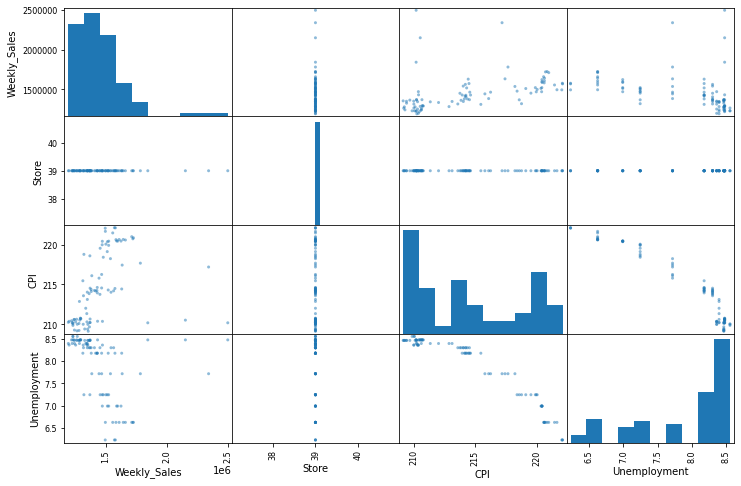

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:100: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:91: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])


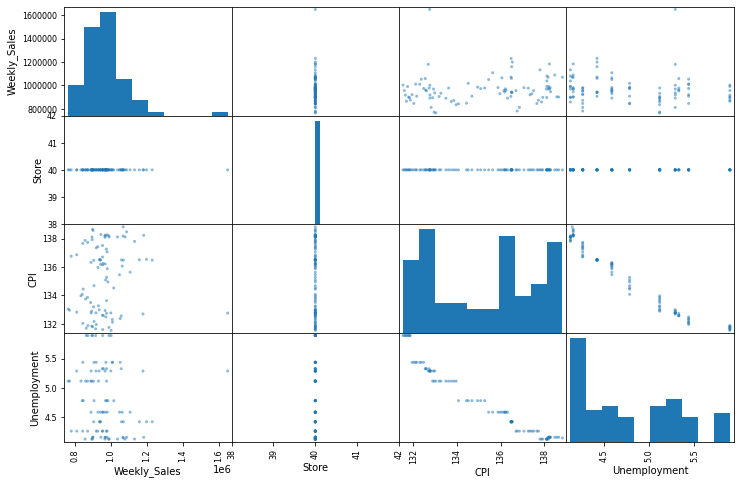

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:100: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:91: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])


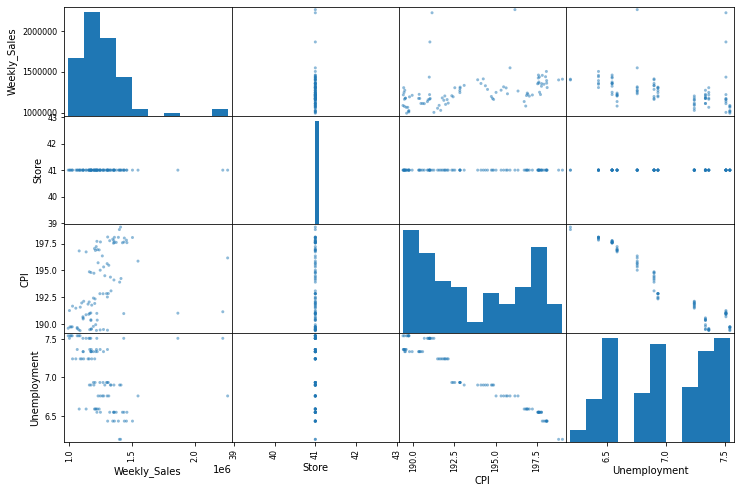

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:100: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:91: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])


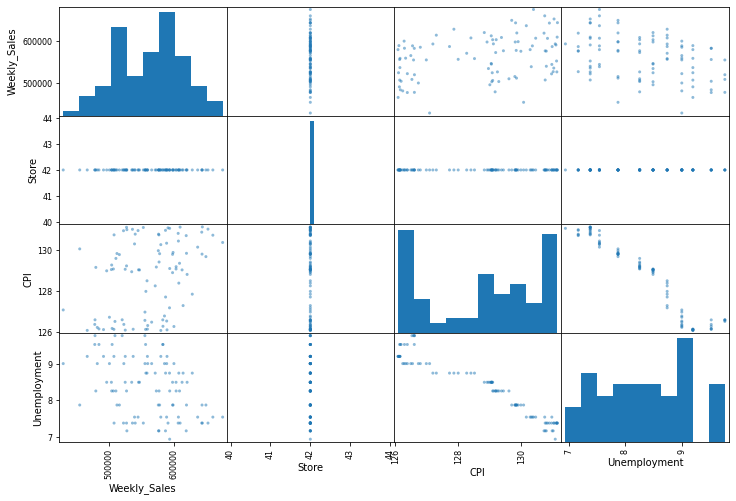

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:100: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:91: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])


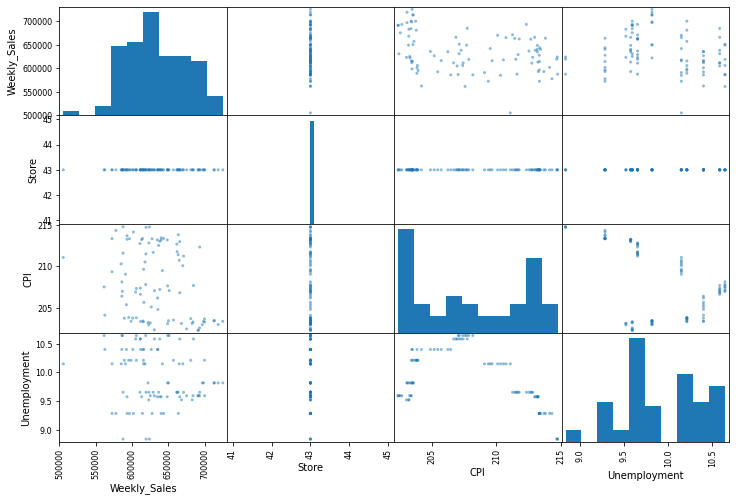

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:100: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:91: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])


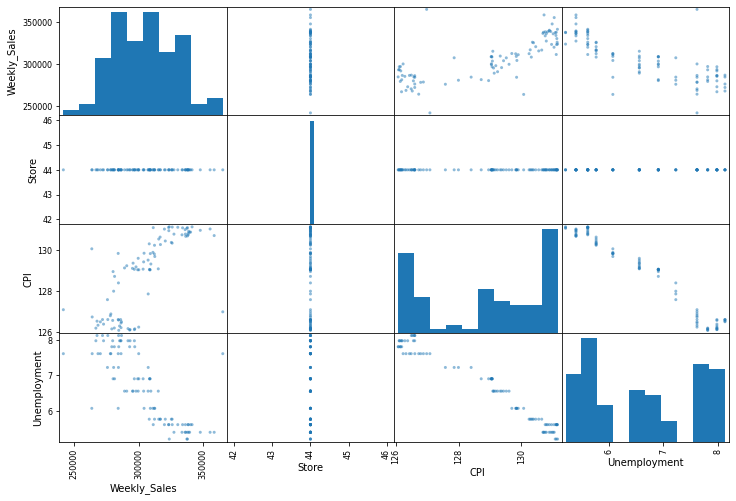

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:100: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/misc.py:91: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])


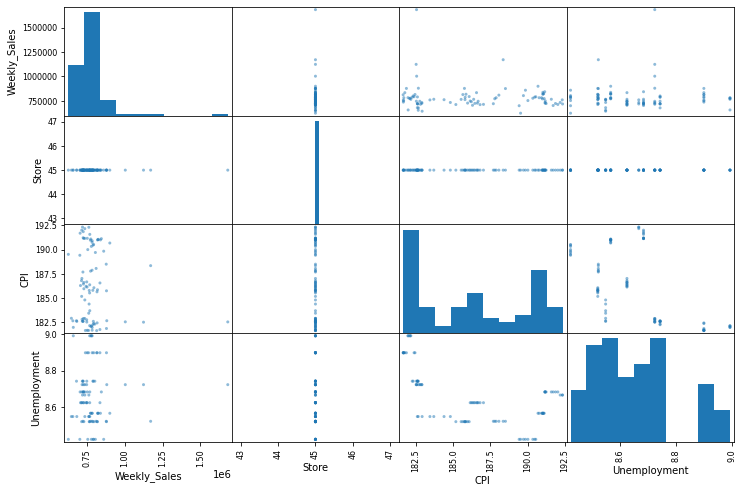

In [119]:
from pandas.plotting import scatter_matrix

attributes = ["Weekly_Sales", "Store", "CPI", "Unemployment"]
for name, group in data.groupby("Store"):
  scatter_matrix(group[attributes], figsize=(12, 8))
  plt.show()

From the scatter plots for each store, it is visible that the relationship between Weekly_Sales and CPI is most of the times rather "curvy" than linear. For the relationship between Weekly_Sales and Unemployment Rate, the analysis is rather difficult, as unemployment rates get published seldomly, a lot of the points are on one level of unemployment.

#### Data Preparation

In [120]:
data[data.isna().any(axis=1)]

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Week,Year,Prev_Week_Sales


No missing values - Good!

In [121]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.preprocessing import OneHotEncoder

default_num_pipeline = make_pipeline(StandardScaler())

log_pipeline = make_pipeline(
 FunctionTransformer(np.log),
 StandardScaler())

label_pipeline = make_pipeline(
 FunctionTransformer(np.log)) 

cat_pipeline = make_pipeline(OneHotEncoder(handle_unknown="ignore"))

preprocessing = ColumnTransformer([
 # scaling for non skewed attributes
 ("normal", default_num_pipeline, ["Temperature"]),
 # log and scaling for skewed/multi-model attributes
 ("log", log_pipeline, ["Fuel_Price", "CPI", "Unemployment"]),
 # one-hot-encoding for week, year and store
 ("cat", cat_pipeline, ["Week", "Year", "Store"]),
 # Log for Prev_Week_Sales
 ("sales", label_pipeline, ["Prev_Week_Sales"]),
 ])

preprocessing_label = ColumnTransformer([
 # Log for Weekly_Sales
 ("log", label_pipeline, ["Weekly_Sales"])
 ])

In [122]:
data = train_set.drop(["Weekly_Sales"], axis=1)
data_label = train_set[["Weekly_Sales"]].copy()
data_prepared = preprocessing.fit_transform(data)

#### Training

I will train a Linear Regression, as well as a RandomForest Model based on the prepared data.

In [148]:
def adjusted_rsquare(y_true, y_pred, **kwargs):
  return -np.sqrt(((np.exp(y_true) - np.exp(y_pred)) ** 2).mean())

neg_exp_root_mean_squared_error = make_scorer(adjusted_rsquare, greater_is_better=True)

In [149]:
from sklearn.linear_model import LinearRegression

data_label_transformed = preprocessing_label.fit_transform(data_label)

lin_reg = make_pipeline(LinearRegression())
lin_reg.fit(data_prepared, data_label_transformed)

lin_rmses = -cross_val_score(lin_reg, data_prepared, data_label_transformed, scoring=neg_exp_root_mean_squared_error, cv=10)

In [151]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer

data_label_transformed = preprocessing_label.fit_transform(data_label)

forest_reg = make_pipeline(RandomForestRegressor(random_state=42))
forest_reg.fit(data_prepared, np.ravel(data_label_transformed))

forest_rmses = -cross_val_score(forest_reg, data_prepared, data_label_transformed, scoring=neg_exp_root_mean_squared_error, cv=10)

/usr/local/lib/python3.9/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.9/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.9/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.9/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the sh

#### Model Evaluation

I validated the model using 10-fold cross-validation. Let's have a look at the RMSE's.

In [152]:
pd.Series(lin_rmses).describe()

count        10.000000
mean      96954.421284
std        9113.358276
min       88468.659640
25%       89894.223861
50%       94907.584141
75%      100760.206402
max      118533.371143
dtype: float64

In [154]:
pd.Series(forest_rmses).describe()

count        10.000000
mean     793727.840346
std       38165.101973
min      743656.323522
25%      764858.031197
50%      790871.171054
75%      821611.465723
max      856779.039396
dtype: float64

Our Linear Model performed way better and is by means of RMSE off only 10 % of the median sales volume for the stores.

#### Testing

In [155]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error

X_test = test_set.drop(["Weekly_Sales"], axis=1)
y_test = test_set[["Weekly_Sales"]].copy()

test_label_transformed = preprocessing_label.fit_transform(y_test)
test_prepared = preprocessing.fit_transform(X_test)
final_predictions = lin_reg.predict(test_prepared)

rmse = mean_squared_error(np.exp(test_label_transformed), np.exp(final_predictions), squared=False)
mae = median_absolute_error(np.exp(test_label_transformed), np.exp(final_predictions))

median_pred = np.median(np.exp(test_label_transformed))
median_actual = np.median(np.exp(final_predictions))

print(rmse)
print(mae)
print(median_pred)
print(median_actual)

93273.47795545786
40176.15968029649
961065.83
967663.3246243938


#### Save Model

In [156]:
import joblib

joblib.dump(forest_reg, "forest_model_on_housing_prices_in_kansas")

['forest_model_on_housing_prices_in_kansas']